# Практический проект по созданию рекомендательной системы

## Industrial and Scientific subset

https://nijianmo.github.io/amazon/index.html#subsets

In [41]:
import scipy.sparse as sparse
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import json
import gzip
import pickle

import random

from lightfm import cross_validation
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

Ratings only: These datasets include no metadata or reviews, but only (user,item,rating,timestamp) tuples.

In [2]:
rating_data = pd.read_csv('Industrial_and_Scientific.csv', header=None)

In [3]:
rating_data.head()

,0,1,2,3
0,0176496920,A3FANY5GOT5X0W,5.0,1358899200
1,0176496920,AT6HRPPYOPHMB,5.0,1352073600
2,0176496920,A4IX7B38LIN1E,4.0,1350432000
3,0176496920,A12Q4LR8N17AOZ,5.0,1490745600
4,0176496920,A1GJXZZPOZ3OD9,1.0,1490054400


In [4]:
rating_data.shape

(1758333, 4)

In [5]:
rating_data.iloc[:,2].head()

0    5.0
1    5.0
2    4.0
3    5.0
4    1.0
Name: 2, dtype: float64

In [6]:
rating_data.iloc[:,2].value_counts()

5.0    1194269
4.0     240812
1.0     141598
3.0     109987
2.0      71667
Name: 2, dtype: int64

В нашем датасете 5 - наиболее часто выставляемый рейтинг, 2 - самый редкий рейтинг

(array([ 141598.,   71667.,  109987.,  240812., 1194269.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

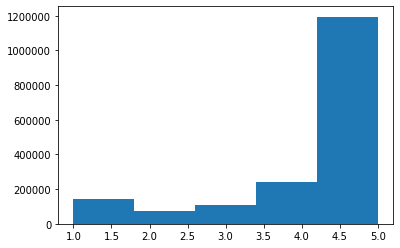

In [7]:
plt.hist(rating_data.iloc[:,2], bins=5)

In [8]:
# сколько юзеры оставили отзывов
users = rating_data.iloc[:,0]
users.value_counts()

B00DRALJ28    14331
B00AZBIZTW    12182
B0013BKDO8    11762
B005KMDV9A     6359
B008YA6BWE     6154
              ...  
B00I2VTERO        1
B01DX1SKTU        1
B004444JV4        1
B00NI9Z4TM        1
B00OI6ESEG        1
Name: 0, Length: 165764, dtype: int64

В нашем датасете 165764 уникальных пользователей оценили товары. Интересно, что максимальное число рейтингов - 14331. Как-то не верится, что один пользователь может оставить столько. Проверим по другим имеющимся датасетам информацию о таких пользователях.

In [9]:
# на сколько товаров оставили отзывы
rating_data.iloc[:,1].value_counts()

A2JZUUAAK3HNHS    156
A3L1VJMHFWONCB    155
A1JTTJ7M7EC7Q7    102
A2W19IAPS7ZSDK     98
A2J2MQ45S3N25N     82
                 ... 
A2ZP6V5WGK7ERU      1
AATPNKU0IO172       1
A2HDDZ5SO3V5T7      1
A1IJKALB8WFSZH      1
AXMMWPZ3VOLBP       1
Name: 1, Length: 1246131, dtype: int64

In [10]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

reviews_data = getDF('Industrial_and_Scientific_5.json.gz')

In [11]:
reviews_data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"11 27, 2017",A1JB7HFWHRYHT7,B0000223SI,{'Size:': ' 1-(Pack)'},Alex W.,This worked really well for what I used it for...,Couldn't have been happier with it's performance,1511740800,NaN,NaN
1,5.0,True,"11 4, 2017",A2FCLJG5GV8SD6,B0000223SI,{'Size:': ' 1-(Pack)'},Randall Harris,Fast cutting and good adheasive.,Good paper.,1509753600,NaN,NaN
2,5.0,False,"10 27, 2017",A3IT9B33NWYQSL,B0000223SI,{'Size:': ' 1-(Pack)'},A. C.,Worked great for my lapping bench. I would li...,Handy!,1509062400,NaN,NaN
3,4.0,True,"01 13, 2018",AUL5LCV4TT73P,B0000223SK,{'Size:': ' 1-Pack'},TnT,As advertised,As advertised,1515801600,NaN,NaN
4,5.0,True,"10 7, 2017",A1V3I3L5JKO7TM,B0000223SK,{'Size:': ' 1-Pack'},John Jones,seems like a pretty good value as opposed to b...,seems like a pretty good value as opposed to b...,1507334400,NaN,NaN


In [12]:
reviews_data[reviews_data.reviewerID ==  'B00DRALJ28']

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image


In [13]:
reviews_data[reviews_data.reviewerID ==  'A2JZUUAAK3HNHS']

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
464,4.0,True,"08 23, 2016",A2JZUUAAK3HNHS,B00004T7W2,"{'Size:': ' 1/4"" Kit'}",Old Sarge,Work as they should.,Work as they should.,1471910400,NaN,NaN
911,3.0,True,"12 30, 2016",A2JZUUAAK3HNHS,B00004YMDG,NaN,Old Sarge,It is what it is............,Three Stars,1483056000,NaN,NaN
4502,5.0,True,"11 24, 2016",A2JZUUAAK3HNHS,B00095V0NC,NaN,Old Sarge,"Great Piece, Works Great!",Five Stars,1479945600,NaN,NaN
5165,3.0,True,"02 14, 2017",A2JZUUAAK3HNHS,B000BO9CJ0,"{'Size:': ' 1/8"" x 1/4""', 'Number of Items:': ...",Old Sarge,"Just what I needed, and Good to Keep Around.",and Good to Keep Around,1487030400,NaN,NaN
8242,3.0,True,"12 16, 2016",A2JZUUAAK3HNHS,B000H9FXEM,NaN,Old Sarge,It worked,Three Stars,1481846400,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72193,5.0,True,"11 24, 2016",A2JZUUAAK3HNHS,B006SJDKBS,NaN,Old Sarge,"Great Piece, Works vevry well!",Five Stars,1479945600,NaN,NaN
73049,5.0,True,"07 25, 2017",A2JZUUAAK3HNHS,B00BGCC9JQ,NaN,Old Sarge,"Just what I Needed, GREAT TOOL!!!",GREAT TOOL!,1500940800,NaN,NaN
74552,5.0,True,"07 25, 2017",A2JZUUAAK3HNHS,B00M3TQ54G,NaN,Old Sarge,"Just what I Needed, GREAT TOOL!!!",GREAT TOOL!,1500940800,NaN,NaN
75336,4.0,True,"12 11, 2017",A2JZUUAAK3HNHS,B00VDRKMTS,NaN,Old Sarge,Works,Four Stars,1512950400,NaN,NaN


Судя по всему, в описании датасета названия колонок user и item переставлены местами. В действительности сначала идет item, потом user.<br>
Итак, у нас __1246131__ уникальных пользователей и __165764__ уникальных товаров, которых эти пользователи оценили.

In [14]:
reviews_data.reviewerID.value_counts()

A3L1VJMHFWONCB    99
A2W19IAPS7ZSDK    64
A2JZUUAAK3HNHS    61
A3OXHLG6DIBRW8    55
A2J2MQ45S3N25N    47
                  ..
A3A2555BBGXNMI     4
A2FGD486F64BYM     4
A2WTWR17KZ8ASZ     4
A15CSHMACOQ70J     3
A36UN90WLZ5X10     2
Name: reviewerID, Length: 11041, dtype: int64

In [15]:
# сколько у нас отзывов пользователей
reviews_data.shape

(77071, 12)

Следующие куски кода для загрузки и конвертации датасетов были взяты [здесь](https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=7Vq32rQd5D9W)

In [16]:
### load the meta data

data = []
with gzip.open('meta_Industrial_and_Scientific.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

167524
{'category': ['Industrial & Scientific', 'Industrial Electrical', 'Semiconductor Products', 'Interfaces', 'Radio Frequency Transceivers'], 'description': ['RCRF-03 - Works on all Turning Technologies RF systems along with RCRF-01 and RCRF-02.'], 'title': 'Turning Technologies Response Card (RCRF-03)', 'also_buy': ['1454894547', '0133455548', '0538741252', '193493139X', '1454882409', '0323295576', '0323512275', '158510048X', '0132911981', '032339020X', '080361571X', '0323310699', '0199782830', '1305968344', '1451192711', '0321972023', '0803659431', '0393614271', '0060556579', '1305616693', '0323265375', '0205992102', '0803644140', '111907732X', 'B002A5DM3U', '032175087X', '0133019934', '1725186527', '1454894776', '1305966066', '0134167546', '007352297X', '0393640345', '0321976495', '1119077257', 'B00HTK1CZG', '1609303377', '0226311511', '113395782X', '0134093410', '0323112021', '0803669453', '1426217986', '0323444199', '0134446526', '0134243064', 'B0018RRSOU', '0815344325', '0321

In [17]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)
print(len(df))

167524


In [18]:
### remove rows with unformatted title (i.e. some 'title' may still contain html style content)

df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
meta_data = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(meta_data))

2045
165479


In [19]:
# how those unformatted rows look like
df4.iloc[0]

category        [Industrial & Scientific, Industrial Electrica...
description     [ACDelco GM Original Equipment Radio Knobs are...
title           var aPageStart = (new Date()).getTime();\nvar ...
also_buy                                             [B0013FDHPQ]
image           [https://images-na.ssl-images-amazon.com/image...
brand                                                     ACDelco
rank            >#1,860,821 in Automotive (See top 100)>#7,832...
main_cat                                               Automotive
price                                                            
asin                                                   B0013FFJM0
tech1           {'Brand': 'ACDelco', 'Item Weight': '0.32 ounc...
feature         [Radios vary based on your vehicle, trim selec...
date                                             February 1, 2008
also_view                                                        
details                                                          
similar_it

In [20]:
meta_data.iloc[0]

category        [Industrial & Scientific, Industrial Electrica...
description     [RCRF-03 - Works on all Turning Technologies R...
title                Turning Technologies Response Card (RCRF-03)
also_buy        [1454894547, 0133455548, 0538741252, 193493139...
image           [https://images-na.ssl-images-amazon.com/image...
brand                                   Turning Technologies, LLC
rank                                12,329inIndustrialScientific(
main_cat                                  Industrial & Scientific
price                                                      $23.61
asin                                                   0176496920
tech1                                                            
feature                                                          
date                                                             
also_view                                                        
details                                                          
similar_it

In [21]:
meta_data.head()

,category,description,title,also_buy,image,brand,rank,main_cat,price,asin,tech1,feature,date,also_view,details,similar_item,tech2,fit
0,"[Industrial & Scientific, Industrial Electrica...",[RCRF-03 - Works on all Turning Technologies R...,Turning Technologies Response Card (RCRF-03),"[1454894547, 0133455548, 0538741252, 193493139...",[https://images-na.ssl-images-amazon.com/image...,"Turning Technologies, LLC","12,329inIndustrialScientific(",Industrial & Scientific,$23.61,0176496920,,,,,,,,
1,,[The only laminated pocket tool that provides ...,R-Cat 692782109 EKG Badge with Arrhythmia Pock...,"[B01NBCNTJ9, B01IAHKULS, B01MT59BRR, 194100406...",[https://images-na.ssl-images-amazon.com/image...,R-Cat,"20,174inIndustrialScientific(",Industrial & Scientific,$20.00,0692782109,,,,,,,,
2,"[Industrial & Scientific, Science Education]","[, Now in its Second Edition,The Spinal Nerves...",Anatomical Chart Company's Illustrated Pocket ...,"[0781776821, 078177683X, 0781776783, 157222684...",,Anatomical Chart Company,">#351,522 in Office Products (See top 100)>#3,...",Office Products,$10.37,0781776848,"{'Brand Name': 'Anatomical Chart Company', 'It...","[MPN: 9780781776844, Authentic Anatomical Char...","August 7, 2007",,,,,
3,"[Industrial & Scientific, Science Education, C...","[, Developed in conjunction with a health prac...",Joints of the Lower Extremities Anatomical Chart,"[0781786630, 1587798085, B004MAJHLW, 078178656...",,Anatomical Chart Company,">#459,493 in Office Products (See top 100)>#39...",Office Products,,0781786606,"{'Brand Name': 'Anatomical Chart Company', 'It...","[MPN: 9780781786607, Authentic Anatomical Char...","February 26, 2009","[B07BCNHC3K, B07D6X5TCB, 1587799839]",,,,
4,"[Industrial & Scientific, Industrial Electrica...",[Advanced digital clicker used in college clas...,Turning Technologies ResponseCard XR RCXR-01,"[0077402286, 1455706124]",[https://images-na.ssl-images-amazon.com/image...,Responsive Innovations,"172,566inIndustrialScientific(",Industrial & Scientific,$32.00,0840026080,,,,,,,,


In [22]:
meta_data['asin'].value_counts()

B00004UDN8    2
B0002FQKFM    2
B00004Z2H0    2
B0002ZP4DQ    2
B00004Z4CW    2
             ..
B00DNW2LQ8    1
B00P6YYMZE    1
B002SJBXES    1
B016PF7IUS    1
B00OI6ESEG    1
Name: asin, Length: 163724, dtype: int64

У нас метаданные о 163724 уникальных товарах. Есть дубли для некоторых товаров. Рассмотрим эти дубли - одинаковая ли в них информация или нет.

In [23]:
double = meta_data.loc[meta_data['asin'] == 'B0000DD0XQ']

In [24]:
double

,category,description,title,also_buy,image,brand,rank,main_cat,price,asin,tech1,feature,date,also_view,details,similar_item,tech2,fit
755,"[Industrial & Scientific, Food Service Equipme...",[Since the first day grizzly started we have b...,Grizzly G9914 Solid Maple Workbench Top,,[https://images-na.ssl-images-amazon.com/image...,Grizzly,">#609,819 in Tools & Home Improvement (See top...",Tools & Home Improvement,,B0000DD0XQ,"{'Part Number': 'G9914', 'Item Weight': '104.2...","[Made of Eastern hard rock (sugar) maple, Coat...","December 1, 2006","[B0000DD362, B00CX5E3FI, B00OI15VBU, B071HLSPD...",,,,
2510,"[Industrial & Scientific, Food Service Equipme...",[Since the first day grizzly started we have b...,Grizzly G9914 Solid Maple Workbench Top,,[https://images-na.ssl-images-amazon.com/image...,Grizzly,">#609,819 in Tools & Home Improvement (See top...",Tools & Home Improvement,,B0000DD0XQ,"{'Part Number': 'G9914', 'Item Weight': '104.2...","[Made of Eastern hard rock (sugar) maple, Coat...","December 1, 2006","[B0000DD362, B00CX5E3FI, B00OI15VBU, B071HLSPD...",,,,


In [25]:
double.loc[755] == double.loc[2510]

category        True
description     True
title           True
also_buy        True
image           True
brand           True
rank            True
main_cat        True
price           True
asin            True
tech1           True
feature         True
date            True
also_view       True
details         True
similar_item    True
tech2           True
fit             True
dtype: bool

In [26]:
double2 = meta_data.loc[meta_data['asin'] == 'B00002N5FK']

In [27]:
double2

,category,description,title,also_buy,image,brand,rank,main_cat,price,asin,tech1,feature,date,also_view,details,similar_item,tech2,fit
135,"[Industrial & Scientific, Industrial Electrica...",[About The Intermatic LC4521C LockingType Phot...,Intermatic LC4521C 120-Volt Locking Type Therm...,"[B003A23HO6, B07DGSJV2B, B002CYVKP6, B00004XSA...",,Intermatic,">#178,611 in Tools & Home Improvement (See top...",Tools & Home Improvement,$6.05,B00002N5FK,"{'Part Number': 'LC4521C', 'Item Weight': '3.2...",[Locking style thermal photocontrol provides d...,"August 17, 2005",,,,,
1890,"[Industrial & Scientific, Industrial Electrica...",[About The Intermatic LC4521C LockingType Phot...,Intermatic LC4521C 120-Volt Locking Type Therm...,"[B003A23HO6, B07DGSJV2B, B002CYVKP6, B00004XSA...",,Intermatic,">#178,611 in Tools & Home Improvement (See top...",Tools & Home Improvement,$6.05,B00002N5FK,"{'Part Number': 'LC4521C', 'Item Weight': '3.2...",[Locking style thermal photocontrol provides d...,"August 17, 2005",,,,,


In [28]:
double2.loc[135] == double2.loc[1890]

category        True
description     True
title           True
also_buy        True
image           True
brand           True
rank            True
main_cat        True
price           True
asin            True
tech1           True
feature         True
date            True
also_view       True
details         True
similar_item    True
tech2           True
fit             True
dtype: bool

Видимо, дубли содержат идентичную информацию.

(array([103236.,  24193.,  11773.,   7407.,   5247.,   4118.,   3106.,
          2510.,   2120.,   1769.]),
 array([    0. ,  1598.7,  3197.4,  4796.1,  6394.8,  7993.5,  9592.2,
        11190.9, 12789.6, 14388.3, 15987. ]),
 <a list of 10 Patch objects>)

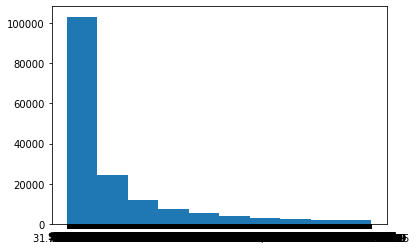

In [29]:
plt.hist(meta_data.price)

In [30]:
rating_data = rating_data.rename(columns={0:'itemId', 1: 'userId', 2:'rating', 3:'timestamp'})

In [31]:
rating_data.head()

,itemId,userId,rating,timestamp
0,0176496920,A3FANY5GOT5X0W,5.0,1358899200
1,0176496920,AT6HRPPYOPHMB,5.0,1352073600
2,0176496920,A4IX7B38LIN1E,4.0,1350432000
3,0176496920,A12Q4LR8N17AOZ,5.0,1490745600
4,0176496920,A1GJXZZPOZ3OD9,1.0,1490054400


In [32]:
users = list(np.sort(rating_data.userId.unique())) 
items = list(rating_data.itemId.unique()) 
rating = list(rating_data.rating)

rows = rating_data.userId.astype('category').cat.codes 
cols = rating_data.itemId.astype('category').cat.codes 
rating_sparse = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(items)))

In [33]:
len(users), len(items)

(1246131, 165764)

In [34]:
matrix_size = rating_sparse.shape[0]*rating_sparse.shape[1] 
num_ratings = len(rating_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_ratings/matrix_size))
sparsity

99.99917120223006

Отложим часть данных для тестирования.

In [43]:
train_set, test_set = cross_validation.random_train_test_split(rating_sparse, test_percentage=0.2)

In [44]:
train_set.shape, test_set.shape

((1246131, 165764), (1246131, 165764))

Построим модель и оценим качество с помощью AUC.

In [46]:
model = LightFM(loss='warp')
model.fit_partial(train_set, epochs=40, num_threads=2)

with open('saved_model','wb') as f:
            saved_model={'model':model}
            pickle.dump(saved_model, f)


train_auc = auc_score(model, train_set).mean()
test_auc = auc_score(model, test_set).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


AUC: train 1.00, test 0.85.
